# 样本不均衡时的处理方法
## 随机采样
  样本比较多的类别，有放回的随机下采样；样本比较少的类别，有放回的随机上采样。     
  假设一个集合中有N个元素，有放回的随机采样出一个新的集合$\bar N$, $|N|=|\bar N|$, 则当$N \rightarrow \infty$ 有大概三成的元素没有出现在
  $\bar N$中。    
  $$
  \lim_{N \rightarrow \infty}(1-\frac{1}{N})^N = \frac{1}{e} = 0.37
  $$
## 基于聚类的采样
  对较多的样本进行聚类，从每个聚类中随机抽取一部分，合并后获得新的集合，这样可以相似的样本被重复抽取到

In [1]:
from mxnet.gluon import data as gdata
from mxnet import nd
import os,sys
import numpy as np
import copy

batch_size = 64

resize = (28,28)

keep_ratios = [1.0, 0.1, 1.0, 0.5, 1.0, 1.0, 1.0, 0.8, 1.0, 0.6]


transformer = []
transformer.append(gdata.vision.transforms.Resize(resize))
transformer += [gdata.vision.transforms.ToTensor()]
transformer = gdata.vision.transforms.Compose(transformer)
    
def load_mnist(batch_size, resize = None):
    mnist_train = gdata.vision.MNIST(train=True,root = 'C:/dataset/mnist/cpp')
    mnist_test = gdata.vision.MNIST(train=False,root = 'C:/dataset/mnist/cpp')
    
    ind_rm = []
    rnds = np.random.rand(len(mnist_train._label))
    ind_rm = [i for i, label in enumerate(mnist_train._label) if rnds[i] > keep_ratios[label]]
    mnist_train_imb = copy.deepcopy(mnist_train)
    print(mnist_train._label.shape)
    mnist_train_imb._label =  np.array( np.delete(mnist_train._label, ind_rm)  )
    print(mnist_train_imb._label.shape)
    mnist_train_imb._data = nd.array( np.delete(mnist_train._data.asnumpy(), ind_rm, axis=0))
    
  

    train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),batch_size,shuffle=True,
                                  last_batch="rollover",num_workers=0)
    
    test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),batch_size,shuffle=False,
                                 last_batch="rollover",num_workers=0)
    
    train_imb_iter = gdata.DataLoader(mnist_train_imb.transform_first(transformer),batch_size,shuffle=True,
                                  last_batch="rollover",num_workers=0)
    
    return train_iter,train_imb_iter,test_iter,mnist_train, mnist_train_imb

def get_class_names():
    text_labels = [str(x) for x in range(10)]
    return text_labels


train_iter, train_imb_iter, test_iter, train_dataset, train_dataset_imb = load_mnist(batch_size,resize=resize)

print("{} {}".format(len(train_dataset), len(train_dataset_imb)))

C:\Users\001\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(60000,)
(47261,)
60000 47261


Distribution of classes in original dataset:


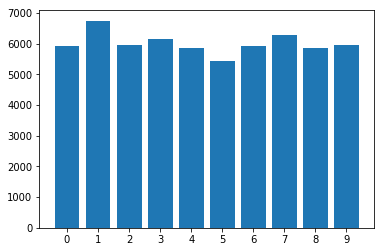

Sampling probability for each class:


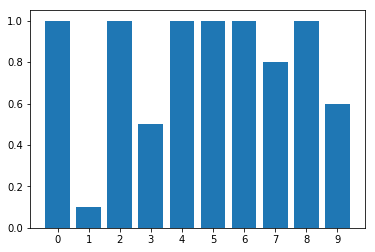

Imbalanced dataset: 47261 training samples & 10000 testing samples

Distribution of classes in imbalanced dataset:


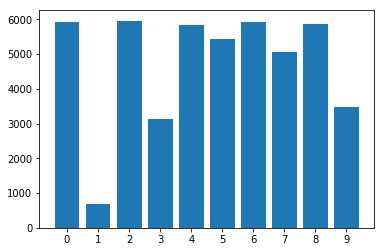

samples from imb dataset


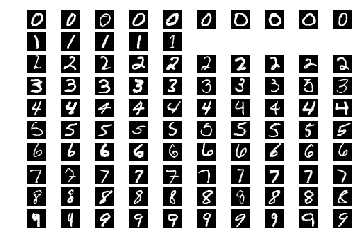

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

class_names = get_class_names()
print('Distribution of classes in original dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(train_dataset._label, return_counts=True)
ax.bar(class_names, counts)
ax.set_xticks(class_names)
plt.show()

print('Sampling probability for each class:')
fig, ax = plt.subplots()
ax.bar(class_names, keep_ratios)
ax.set_xticks(class_names)
plt.show()
 

print('Imbalanced dataset: %d training samples & %d testing samples\n' % (
    len(train_dataset_imb), len(test_iter._dataset)))

print('Distribution of classes in imbalanced dataset:')
fig,cx = plt.subplots()
_, counts = np.unique(train_dataset_imb._label, return_counts=True)
cx.bar(class_names, counts)
cx.set_xticks(class_names)
plt.show()

def show_mnist(data_iter):
    Xs = []
    Ys = []
    for batch in data_iter:
        X,Y = batch
        X = X.asnumpy()[0,0]
        Y = Y.asnumpy()[0]
        Xs.append(X)
        Ys.append(Y)

    label_showed = {}
    fig = plt.figure()
    for ind, (X,Y) in enumerate(zip(Xs,Ys)):
        if Y in label_showed and label_showed[Y] + 1 > 10:
            continue
        if Y not in label_showed:
            label_showed[Y] = 1
        else:
            label_showed[Y] += 1
        ax = fig.add_subplot(10,10, label_showed[Y] + Y * 10)
        ax.imshow(X,cmap='gray')
        ax.axis('off')
    plt.show()
    
print('samples from imb dataset')
show_mnist(train_imb_iter)







In [3]:
from mxnet.gluon import nn
import mxnet as mx
import sklearn.metrics as sm
import pdb
import seaborn as sns
import pandas as pd

ctx = mx.gpu()
class SimpleNet(nn.Block):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.stages = nn.Sequential("")
        self.stages.add(
            nn.Conv2D(10,kernel_size = 5,padding=2,activation="relu"),
            nn.MaxPool2D(2,2),
            nn.Conv2D(20,kernel_size = 5,padding=2,activation="relu"),
            nn.MaxPool2D(2,2),
            nn.GlobalAvgPool2D(),
            nn.Dense(64),
            nn.Dropout(0.5),
            nn.Dense(10)
        )

    def forward(self, x):
        return self.stages(x)
    

    



def one_step(trainer,net,train_iter):
    cls_loss = mx.gluon.loss.SoftmaxCrossEntropyLoss()
    for batch_idx, (X, Y) in enumerate(train_iter):
        X = X.as_in_context(ctx)
        with mx.autograd.record(True):     
            output = net(X).as_in_context(mx.cpu())
            loss = cls_loss(output, Y)
        loss.backward()
        trainer.step(batch_size)

def test(net,test_iter):
    correct = 0
    targets, preds = [], []
    
    for X,Y in test_iter:
        X,Y = X.as_in_context(ctx), Y.asnumpy()
        output = net(X)
        pred = output.asnumpy().argmax(1)
        #pdb.set_trace()
        correct += (Y == pred).sum()
        preds.extend(pred.tolist())
        targets.extend(Y.tolist())

    test_acc = 100. * correct / len(targets)
    confusion_mtx = sm.confusion_matrix(targets, preds)
    return test_acc, confusion_mtx

def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()
           
def run_train_test(train_loader,N):
   
    model = SimpleNet()
    model.initialize()
    model.collect_params().reset_ctx(ctx)
    #print(model)

    base_lr = 0.01
    num_epochs = 100
    wd = 0.0005
    iter_per_epoch = N // batch_size
    lr_sch = mx.lr_scheduler.PolyScheduler(max_update= iter_per_epoch * num_epochs,base_lr=base_lr, pwr=1)
    trainer = mx.gluon.Trainer(model.collect_params(),optimizer="sgd",optimizer_params={"wd":wd})

    test_accs, confusion_mtxes = [], []    
    for epoch in range(1, num_epochs+1):
        trainer.set_learning_rate(lr_sch((epoch-1)*iter_per_epoch ))
        one_step(trainer,model,train_loader)
        if (epoch % 5) == 0:
            test_acc, confusion_mtx = test(model,test_iter)
            test_accs.append(test_acc)
            confusion_mtxes.append(confusion_mtx)
            print('\rBest test acc = %2.2f%% @ epoch %d' %(max(test_accs),epoch), end='', flush=True)

    vis(test_accs, confusion_mtxes, class_names)

有放回的随机采样，采样后每个类别样本数相等

random sampling:  (60000, 28, 28, 1)   60000


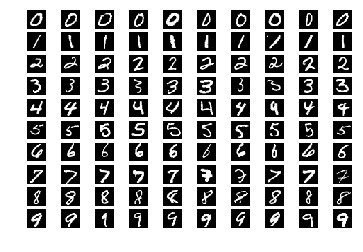

Distribution of classes in random resampling dataset:
[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


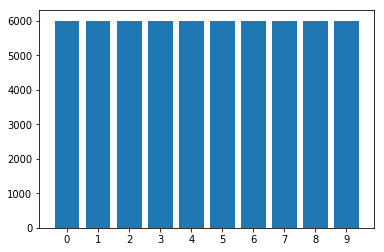

In [8]:
def sampling_with_replace(src_ds, num_req_per_label):
    def get_label_data():
        data,label = [],[]
        for y in range(10):
           # pdb.set_trace()
            inds = [k for k in range(len(src_ds._label)) if src_ds._label[k] == y]
            data = src_ds._data.asnumpy()[inds]  
            label = src_ds._label[inds]
            yield data,label
            data,label = [],[]
    new_label,new_data = [],[]
    for data, label in get_label_data():
        inds = np.random.randint(0, high=len(label),size=num_req_per_label)
        #if label[0] == 1:
        #    pdb.set_trace()
        new_label.extend([label[0] for k in range(num_req_per_label)])
        new_data.append( [data[k] for k in inds ])
    new_ds = copy.deepcopy(src_ds)
    #new_label = [np.reshape(l, (-1,1)) for l in new_label]
    new_ds._label = np.asarray(new_label)
    new_ds._label.shape = len(new_ds._label)
    new_ds._data = nd.array(np.vstack(new_data))
    return new_ds
        
    
dataset_random_sampling = sampling_with_replace(train_dataset_imb, 6000)
print('random sampling: ',dataset_random_sampling._data.shape, ' ', len(dataset_random_sampling._label))

train_rnd_sampling_iter = gdata.DataLoader(dataset_random_sampling.transform_first(transformer),batch_size,shuffle=True,
                                  last_batch="rollover",num_workers=0)


show_mnist(train_rnd_sampling_iter)

print('Distribution of classes in random resampling dataset:')
fig,cx = plt.subplots()
_, counts = np.unique(dataset_random_sampling._label, return_counts=True)
print(counts)
cx.bar(class_names, counts)
cx.set_xticks(class_names)
plt.show()






train with random sampling dataset
Best test acc = 95.26% @ epoch 100

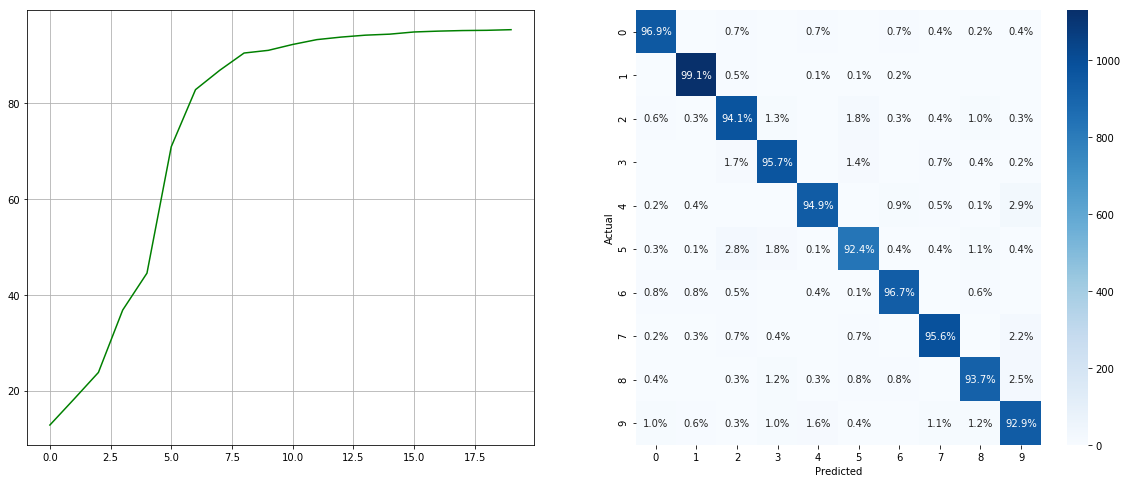

train with imbalanced dataset
Best test acc = 90.42% @ epoch 100

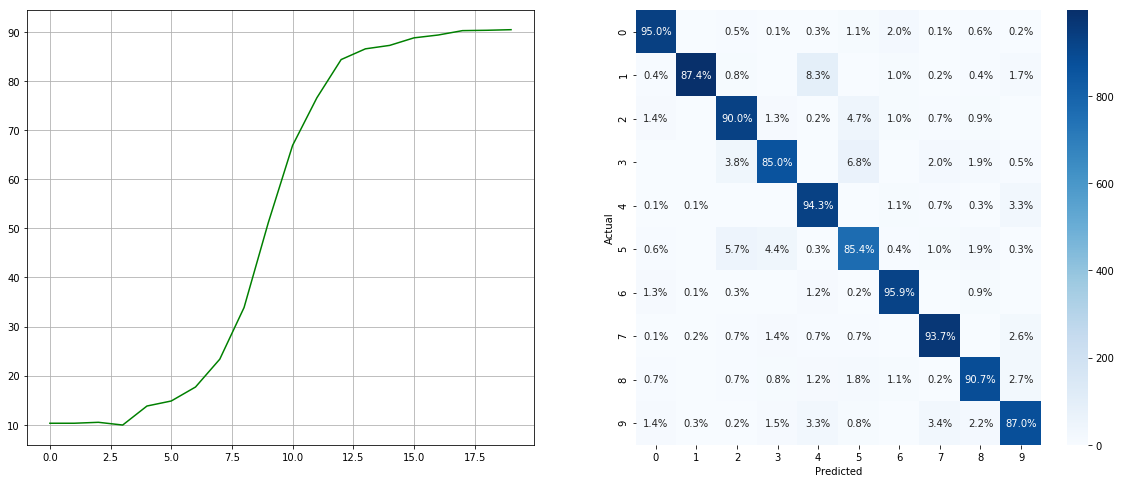

train with full dataset
Best test acc = 95.52% @ epoch 100

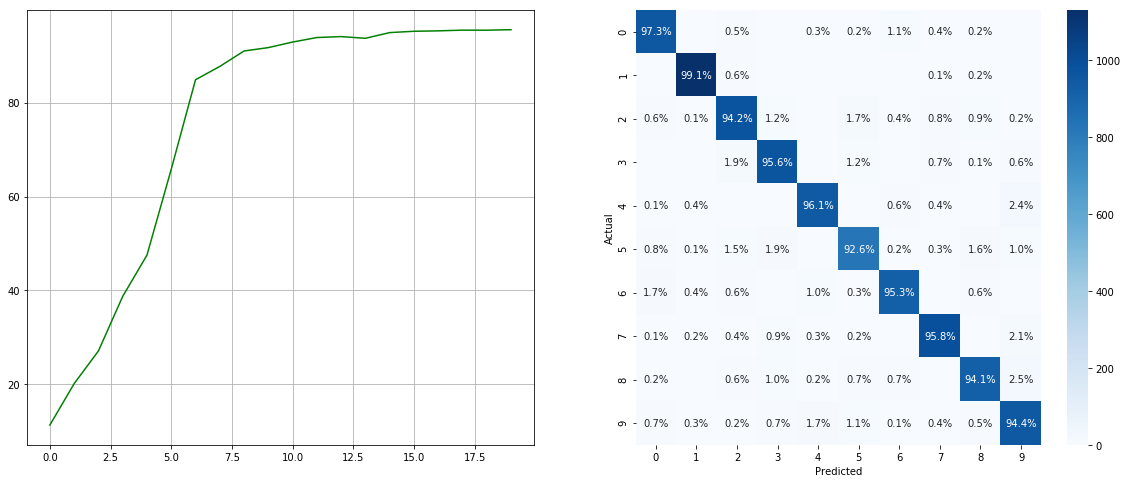

In [9]:



print('train with random sampling dataset')
run_train_test(train_rnd_sampling_iter, len(dataset_random_sampling))

print('train with imbalanced dataset')
run_train_test(train_imb_iter, len(train_dataset_imb))


print('train with full dataset')
run_train_test(train_iter, len(train_dataset))



样本不均衡，容易导致样本较少的